# Precipitaion Forecasting
In this project, we have trained different types of machine learning models on some data about weather to predict precipitation.

## Introduction
_Weather forecasting_ is using data about the current state and predict how the atmosphere will change. Weather warnings are used to protect lives and property, weather forecasting improves transportation safety, and precipitation forecasting is important to agriculture. There are many different ways of weather prediction. We have used machine learning models and compared the predicted results with actual values.
#### Study area
Basel is a city in northwest Switzerland. On average $51\%$ days of the year have precipitation more than $0.1mm$. The total precipitation is around $850 mm$ annually.
#### Methodology
At first, data is collected. Then, some preprocessing techniques are used to prepare data for machine learning models. Finally, different machine learning techniquies are applied and the accuracy for each is reported.\
The following libraries are used: `numpy`, `pandas`, `matplotlib`, `scikit-learn`, `keras`

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import  make_pipeline
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers.legacy import Adam
from keras.losses import MeanSquaredError
from scikeras.wrappers import KerasRegressor

from utils import *
%matplotlib widget

## Dataset
**You can find and download the dataset in [this](https://www.meteoblue.com/en/weather/archive/export) link.**
#### About dataset
This dataset contains some attributes about weather for Basel, from *January, 2014* to *November, 2023* with hourly resolution. The first nine rows are some basic information about location of city and units of measurements which we do not need it.

In [2]:
data = load_data()
print(data.shape)

(86664, 7)


At the initial stage, there are $86664$ _samples_ and $7$ parameters.
#### Cleaning dataset
There are some rows at the end of dataset which are empty, _missing data_. We simply drop them. A day after the missing data is not complete. For simplicity we remove this day as well.

In [3]:
missing_data = drop_missing_data(data)
print(missing_data)

191


As we can see, number of missing rows is $191$.
#### Parameters
In our data, each row represents a sample and each column represents a feature. Here is the list of columns measured hourly. This list is raw and we will do some operations to get ready for models.
> Level column gives the height of the measurment from the sea level.

| Symbol        | Parameter                 | Level                     | Unit          |
|:-------------:|:-------------------------:|:-------------------------:|:-------------:|
| $\text{T}$    | Temperature               | $2 m$ elevation corrected | $°C$          |
| $\text{PT}$   | Precipitation Total       | sfc                       | $mm$          |
| $\text{RH}$   | Relative Humidity         | $2 m$                     | $\%$          |
| $\text{WS}$   | Wind Speed                | $100 m$                   | $km/h$        |
| $\text{WD}$   | Wind Direction            | $100 m$                   | $°$           |
| $\text{CCT}$  | Cloud Cover Total         | sfc                       | $\%$          |
| $\text{MSL}$  | Mean Sea Level Pressure   | MSL                       | $\text{hPa}$  |

## Preprocessing
#### Make samples daily
Forecasting for a whole day is more general than one hour, so we decided to merge each $24$ sample to convert the resolution to daily.
- We extract **maximum**, **minimum**, and **mean** from each day of all parameters.
- Except **Precipitation** which should be the **sum**.

In [4]:
daily_data = change_resolution_to_daily(data)
daily_data

PT     TMEAN     RHMEAN     WSMEAN      WDMEAN    CCTMEAN  \
Year Month Day                                                                
2014 1     1     1.4  4.494412  90.203694  16.615975  166.495278  59.916667   
           2     6.8  5.978995  92.044333  20.621631  184.099628  63.875000   
           3     0.8  6.586079  88.778159  22.263927  183.268500  50.108334   
           4    16.5  6.358579  94.172092  15.272616  158.277724  66.666667   
           5     5.5  4.995662  86.622807  16.897822  225.090521  59.383333   
...              ...       ...        ...        ...         ...        ...   
2023 11    8     0.0  7.268995  82.063136  17.965620  202.643658  33.016667   
           9     4.2  7.729829  82.235617  25.143419  196.132513  69.020834   
           10    9.3  9.101078  76.940065  27.342357  228.518643  61.875000   
           11    3.2  7.350245  82.186650  22.030794  242.243293  49.875000   
           12   14.0  5.818162  93.582846  18.648649  181.010854  85.333333   

                    MSLMEAN       TMAX      RHMAX      WSMAX      WDMAX  \
Year Month Day                                                            
2014 1     1    1014.029167   8.720245  96.163430  18.455048  202.01129   
           2    1008.670833   9.240245  97.294250  29.215502  223.78113   
           3    1013.070833  10.400246  97.533720  29.142216  210.57922   
           4    1007.625000   8.480246  98.024340  28.100763  205.51387   
           5    1010.754167   7.480245  97.288110  27.103000  253.00919   
...                     ...        ...        ...        ...        ...   
2023 11    8    1019.379167  12.380245  93.924965  22.148046  225.65854   
           9    1010.795833  10.380245  91.075330  31.259941  216.73283   
           10   1005.745833  10.670245  91.051674  36.932910  244.13365   
           11   1010.391667   8.660245  93.756410  38.017090  261.06042   
           12   1010.112500  11.230246  97.743355  38.821620  246.72710   

                CCTMAX  MSLMAX      TMIN      RHMIN      WSMIN      WDMIN  \
Year Month Day                                                              
2014 1     1      99.0  1017.0  0.310245  77.926410  13.584932  144.46231   
           2     100.0  1012.1  3.530245  83.382390  14.759999  152.35402   
           3     100.0  1016.1  2.340245  79.372375  15.716793  157.79652   
           4     100.0  1016.3  4.600245  88.295070   7.244860  135.00000   
           5     100.0  1016.2  0.440245  69.289240   7.100310  178.15239   
...                ...     ...       ...        ...        ...        ...   
2023 11    8      79.0  1021.9  3.760245  60.761055  13.104198  172.87498   
           9     100.0  1014.6  3.690246  74.427025  18.014393  177.70940   
           10    100.0  1006.9  7.960245  53.971973  23.188583  206.56505   
           11     78.0  1013.0  4.260245  73.603580  13.905509  201.25050   
           12    100.0  1012.9  2.140245  85.583810  11.486200  130.23636   

                   CCTMIN  MSLMIN  
Year Month Day                     
2014 1     1    30.000002  1009.0  
           2     6.000000  1005.9  
           3    14.000000  1011.4  
           4     5.000000   999.5  
           5    10.800000  1000.1  
...                   ...     ...  
2023 11    8     5.000000  1014.8  
           9    26.700000  1007.6  
           10   24.000000  1004.4  
           11   17.000000  1004.7  
           12   14.000000  1008.1  

[3603 rows x 19 columns]

Now we have $18$ _features_ and $3603$ _samples_. $\text{PT}$ is actually the target value.\
For saving time, we write daily data in a file.

In [5]:
write_daily_data(daily_data)

In [6]:
X, y = read_daily_data()

#### Splitting data
We split our data into *train* and *test* sets with relative size $70/30$.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2522, 18) (1081, 18) (2522,) (1081,)


#### Visualize parameters distribution
A [histogram](https://www.investopedia.com/terms/h/histogram.asp#:~:text=A%20histogram%20is%20a%20graph,how%20often%20that%20variable%20appears) is a graph that shows the frequency of numerical data using rectangles. The height of each rectangle represents the distribution frequency of a variable. The width of the rectangle represents the value of the variable. Here is the histogram for the first 6 features and target value.

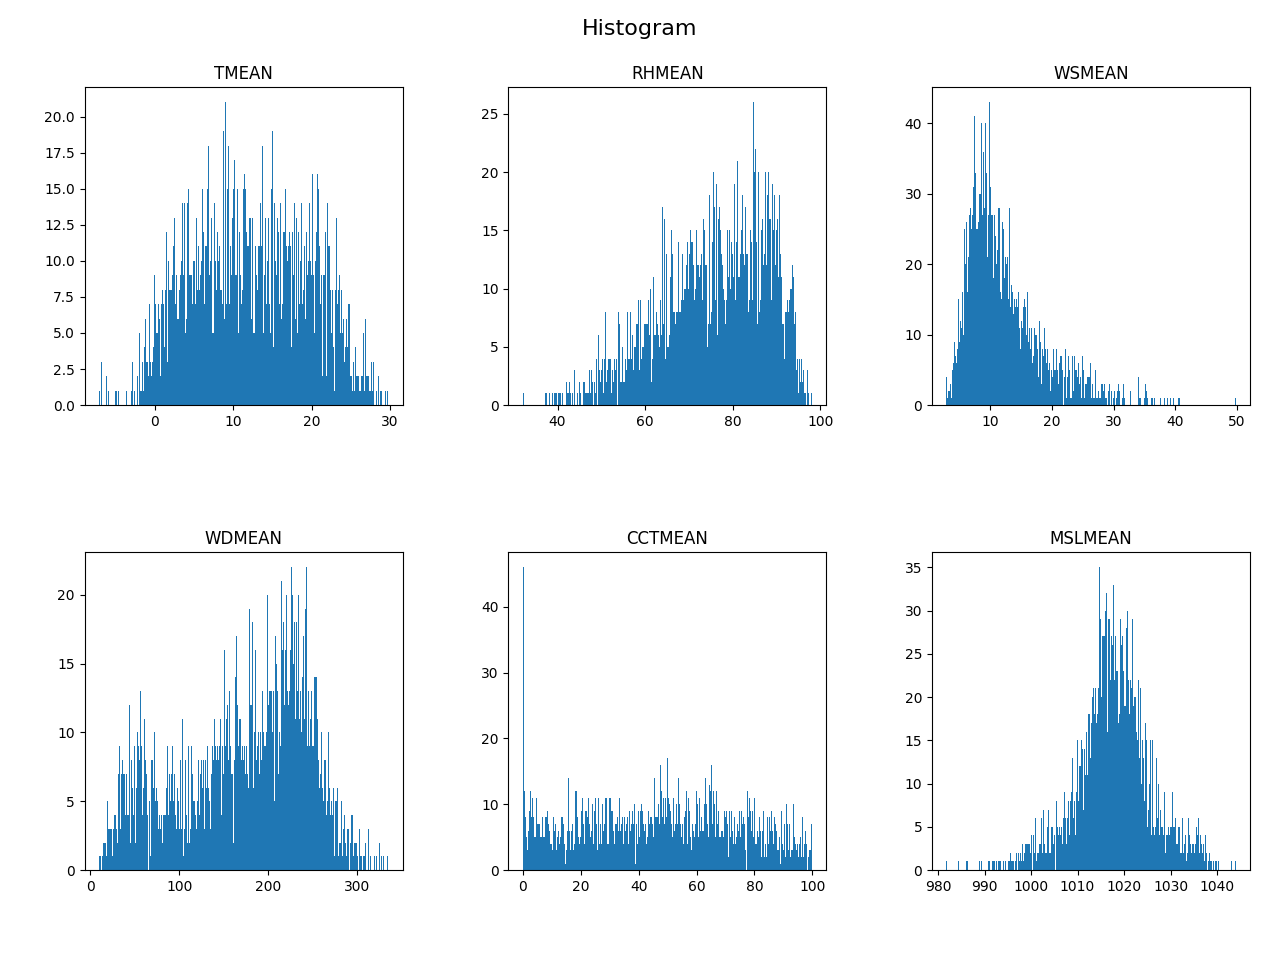

In [8]:
show_histogram(X_train.values, titles=X_train.columns)

#### Normalization
In general, many learning algorithms such as linear models benefit from standardization of the data set. Since some features like $\text{MEANMSL}$ are numerically larger than others, we should sacle features. 


We standardize features by removing the mean and scaling to unit variance.
$$ z = \frac{x - \mu}{\sigma} $$
We find parameters of nomalization only by having *training set* and **do not** recalculate them on the *test set*.

In [9]:
std = StandardScaler()

## Models
For precipitation forecating, we have two options:
- Quantitative Precipitation Forecast (QPF) that foreacst the amount of precipitation.
- Predict whether it will rain or not.
### Regression
We use $R^2$ technique for measuring accuracy. If $\hat{y_i}$ is the predicted value for $i$-th sample:
$$ R^2 (y, \hat{y}) = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y_i})^2}{\sum_{i=1}^n (y_i - \bar{y_i})^2} $$
#### Linear Model
In this model, target value is expected to be a linear combination of the features.

We use [Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) that has cost *least squares* with *l2 regularization*.
SGDRegressor(loss='squared_error', penalty='l2') and Ridge solve the same optimization problem, via different means. [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor) is well suited for regression problems with a large number of training samples (> 10.000). For other problems like ours, Ridge is recommended.

**Tuning hyper-parameters**: We only tune $\text{alpha}$ (regularization term) here.

In [10]:
ridge_grid = {
    "alpha": [0.001, 0.01, 0.1, 1, 10]
}
ridge_reg = Ridge(random_state=42)
ridge_search = GridSearchCV(ridge_reg, ridge_grid, scoring="r2")
ridge_model = make_pipeline(std, ridge_search).fit(X_train, y_train)
search_results(ridge_search)

,rank_test_score,mean_test_score
hyper params,,
1,1,0.470393
0.1,2,0.470236
0.01,3,0.470203
0.001,4,0.470200
10,5,0.468775


Now we found that $\text{alpha} = 1$ is the best possible choice, we start predicting.

In [11]:
linear_model = make_pipeline(std, ridge_search.best_estimator_).fit(X_train, y_train)
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)
linear_score = score_model(r2_score, y_train, y_train_pred, y_test, y_test_pred, "Linear")
linear_score

,Train Score,Test Score
Linear,0.481361,0.430302


#### Random Forest
A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. This is one of the models that is **not sensitive to the scale** of the input features.

We tune only on $\text{n\_estimators}$.

In [12]:
rfr_grid = {
    "n_estimators": [10, 60, 100, 500]
}
rfr = RandomForestRegressor(random_state=42)
rfr_search = GridSearchCV(rfr, rfr_grid, scoring="r2").fit(X_train, y_train)
search_results(rfr_search)

,rank_test_score,mean_test_score
hyper params,,
500,1,0.580371
100,2,0.575937
60,3,0.570216
10,4,0.540324


Although maybe $\text{n\_estimators} > 500$ would be better, it is very time consuming to choose larger values. So we use $\text{n\_estimators} = 500$ instead which is not really worse but very faster.

In [13]:
rfr_model = rfr_search.best_estimator_.fit(X_train, y_train)
y_train_pred = rfr_model.predict(X_train)
y_test_pred = rfr_model.predict(X_test)
rfr_score = score_model(r2_score, y_train, y_train_pred, y_test, y_test_pred, "RandomForest")
rfr_score

,Train Score,Test Score
RandomForest,0.943177,0.551559


There is an interesting fact about this model. It is trained on Train set very well, but accuracy decreases dramaticaly when predicting Test set.

#### Gradient Boosting
Another ensemble model.
In each stage a regression tree is fit on the negative gradient of the given loss function.

Here, we tune on $\text{n\_estimators}$, and also $\text{learning\_rate}$.

In [14]:
grb_grid = {
    "n_estimators": [10, 60, 100, 500],
    "learning_rate": [0.05, 0.1, 0.5]
}
grb = GradientBoostingRegressor(random_state=42)
grb_search = GridSearchCV(grb, grb_grid, scoring="r2").fit(X_train, y_train)
search_results(grb_search)

,rank_test_score,mean_test_score
hyper params,,
0.1_100,1,0.578455
0.1_60,2,0.574536
0.05_100,3,0.574322
0.05_500,4,0.569236
0.1_500,5,0.558686
0.05_60,6,0.546302
0.5_10,7,0.543708
0.5_60,8,0.496438
0.5_100,9,0.477326


From the above table we can conclude that is not always more accure.

For prediction we use this code.

In [15]:
grb_model = grb_search.best_estimator_.fit(X_train, y_train)
y_train_pred = grb_model.predict(X_train)
y_test_pred = grb_model.predict(X_test)
grb_score = score_model(r2_score, y_train, y_train_pred, y_test, y_test_pred, "Gradient Boosting")
grb_score

,Train Score,Test Score
Gradient Boosting,0.793528,0.596612


Comparing to Random Forest, although Gradient Boosting score on Train set is lower, but can predict better on Test set.

#### Nueral Networks
We use `keras` for implementing nueral networks. Here are some structures.

In general, decision trees have better performance on structured data rather than nueral nerworks.

In [16]:
nn_model1 = Sequential([
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dense(1, activation="relu")
], name="nn_model1")

nn_model2 = Sequential([
    Dense(15, activation="relu"),
    Dense(7, activation="relu"),
    Dense(1, activation="relu")
], name="nn_model2")

nn_model3 = Sequential([
    Dense(8, activation="relu"),
    Dense(1, activation="relu")
], name="nn_model3")

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)
dfs = []

for nn_model in [nn_model1, nn_model2, nn_model3]:
    nn_model.compile(optimizer=Adam(learning_rate=4e-2), loss="mean_squared_error")
    nn_model.fit(X_train_std, y_train)
    y_train_pred = nn_model.predict(X_train_std)
    y_test_pred = nn_model.predict(X_test_std)
    dfs.append(score_model(r2_score, y_train, y_train_pred, y_test, y_test_pred, nn_model.name))

nn_score = pd.concat(dfs)
nn_score

2023-12-11 01:03:37.619841: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-11 01:03:37.619866: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-11 01:03:37.619872: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-11 01:03:37.619907: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-11 01:03:37.619927: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-11 01:03:38.216337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 0s 2ms/step


,Train Score,Test Score
nn_model1,0.515692,0.436504
nn_model2,0.382449,0.408192
nn_model3,0.526598,0.457416


### Classification

## Conclusion
For Regression part, Gradient Boosting has the highest *r2_score*.

In [17]:
regression_scores = pd.concat([linear_score, rfr_score, grb_score, nn_score])
regression_scores.sort_values(by="Test Score", ascending=False)

,Train Score,Test Score
Gradient Boosting,0.793528,0.596612
RandomForest,0.943177,0.551559
nn_model3,0.526598,0.457416
nn_model1,0.515692,0.436504
Linear,0.481361,0.430302
nn_model2,0.382449,0.408192
